In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
# load modules
import torch
import torch.distributions as D
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [8]:
def create_blr_problem(dim, seed):
    signal_std = 1e-1
    prior_alpha = 1
    num_training = dim
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=prior_alpha,
                            signal_std=signal_std,
                            num_targets=2 * num_training,
                            seed=seed,
                            num_train_points=num_training)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [9]:
def compute_preds(d, blr_obj, training_data=False):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [66]:
def true_preds(blr_obj, training_data=False, seed=0):
    torch.manual_seed(seed)
    samples = blr_obj.weight_posterior.sample((500,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [67]:
def var_approx_preds(blr_obj, training_data=False, seed=0):
    torch.manual_seed(seed)
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((500,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [68]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = D.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [69]:
def make_gmm(preds, signal_std):
    mix = D.Categorical(torch.ones(preds.shape[1]))
    comp = D.Normal(loc=preds.permute(0, 2, 1), scale=b.signal_std)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

In [70]:
def compute_gaussian_likelihood(preds, y, b):
    # make normal using preds and signal noise
    m = preds.mean(1).to('cpu')
    s_al = (preds.var(1).to('cpu') + b.signal_std ** 2) ** 0.5
    
    return D.Normal(loc=m, scale=s_al).log_prob(y).sum(1)

In [71]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

# Ensemble LL

## Test set

In [581]:
epsilons = [-0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3, 0.4]
dim = 50
beamwidth = 5
emp = []
vari = []
hard = False
emp_epsilons = []
vari_epsilons = []
for eps in epsilons:
    try:
        vari.append(pkl.load(open(f"PickledStuff/BLR_RESULTS_v2/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
        vari_epsilons.append(eps)
    except:
        pass
    try:    
        emp.append(pkl.load(open(f"PickledStuff/BLR_RESULTS_v2/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
        emp_epsilons.append(eps)
    except:
        pass

In [582]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [583]:
t.log_prob(t.sample((50,))).mean()

tensor(116.6054)

In [584]:
emp_epsilons

[-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]

In [585]:
prior = D.MultivariateNormal(loc=torch.zeros_like(t.mean), covariance_matrix=torch.eye(dim))

emp_kl = D.kl_divergence(t, prior)
var_kl = D.kl_divergence(compute_variational_posterior(t), prior)
print(f"Emp kl: {emp_kl.item():.2f}, Var kl: {var_kl.item()}")

Emp kl: 195.36, Var kl: 219.0374861579449


In [586]:
emp_coding_efficiency = [compute_expected_coding_efficiency(emp_kl, epsilon=e).item() for e in emp_epsilons]

In [587]:
var_coding_efficiency = [compute_expected_coding_efficiency(var_kl, epsilon=e).item() for e in vari_epsilons]

In [588]:
exact_log_probs = make_gmm(true_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test).sum(-1)

In [589]:
exact_var_log_probs = make_gmm(var_approx_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test).sum(-1)

In [590]:
vari_full_preds = torch.zeros(len(vari), 500, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(emp), 500, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    try:
        emp_full_preds[i] = compute_preds(emp[i], b)
    except:
        pass
    try:
        vari_full_preds[i] = compute_preds(vari[i], b)
    except:
        pass

In [591]:
var_gmm = make_gmm(vari_full_preds, signal_std=b.signal_std)
var_log_probs = var_gmm.log_prob(b.regression_targets_test).sum(-1)

In [592]:
emp_gmm = make_gmm(emp_full_preds, signal_std=b.signal_std)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test).sum(-1)

In [593]:
map_log_likelihood = torch.sum(D.normal.Normal(loc=b.empirical_prediction(t.mean), scale=b.signal_std).log_prob(b.regression_targets_test))

In [594]:
torch.tensor(emp_coding_efficiency + var_coding_efficiency)

tensor([142.6772, 162.3458, 181.9989, 201.6396, 221.2705, 240.8931, 260.5087,
        280.1185, 159.3653, 181.4018, 203.4227, 225.4313, 247.4299, 269.4203,
        291.4038, 313.3815])

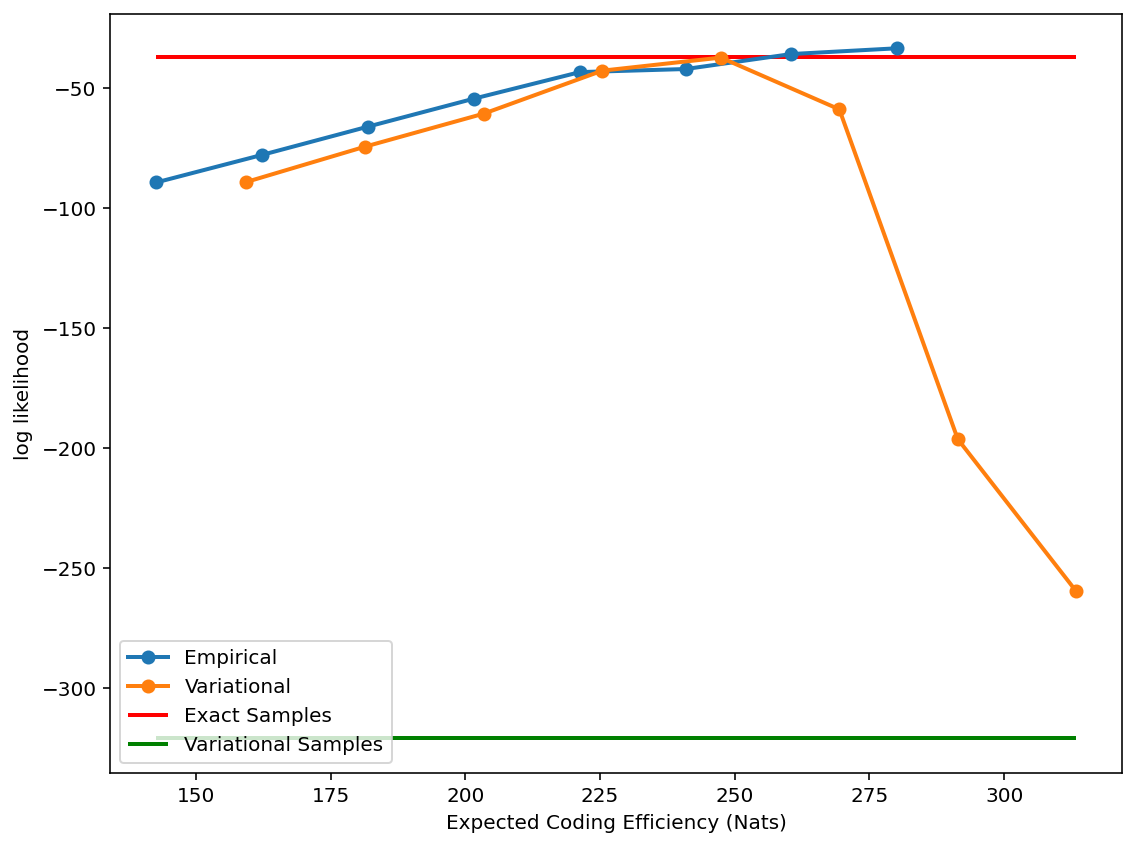

In [595]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(emp_coding_efficiency, emp_log_probs, '-o', label='Empirical')
ax.plot(var_coding_efficiency, var_log_probs, '-o', label='Variational')
min_x = torch.min(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
max_x = torch.max(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
ax.hlines(exact_log_probs, xmin=min_x, xmax=max_x, color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs, xmin=min_x, xmax=max_x, color='green', label='Variational Samples')
ax.set_xlabel(r'Expected Coding Efficiency (Nats)')
ax.set_ylabel('log likelihood')
ax.legend()
#ax.set_ylim([-100, exact_log_probs + 10])
fig.tight_layout()

## Training set

In [596]:
exact_log_probs_train = make_gmm(true_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train).sum(-1)

In [597]:
exact_var_log_probs_train = make_gmm(var_approx_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train).sum(-1)

In [598]:
vari_full_preds_train = torch.zeros(len(vari), 500, len(b.regression_targets_train))
emp_full_preds_train = torch.zeros(len(emp), 500, len(b.regression_targets_train))
for i, _ in enumerate(epsilons):
    try:
        emp_full_preds_train[i] = compute_preds(emp[i], b, training_data=True)
    except:
        pass
    try:
        vari_full_preds_train[i] = compute_preds(vari[i], b, training_data=True)
    except:
        pass

In [599]:
var_gmm = make_gmm(vari_full_preds_train, signal_std=b.signal_std)
var_log_probs_train = var_gmm.log_prob(b.regression_targets_train).sum(-1)

In [600]:
emp_gmm = make_gmm(emp_full_preds_train, signal_std=b.signal_std)
emp_log_probs_train = emp_gmm.log_prob(b.regression_targets_train).sum(-1)

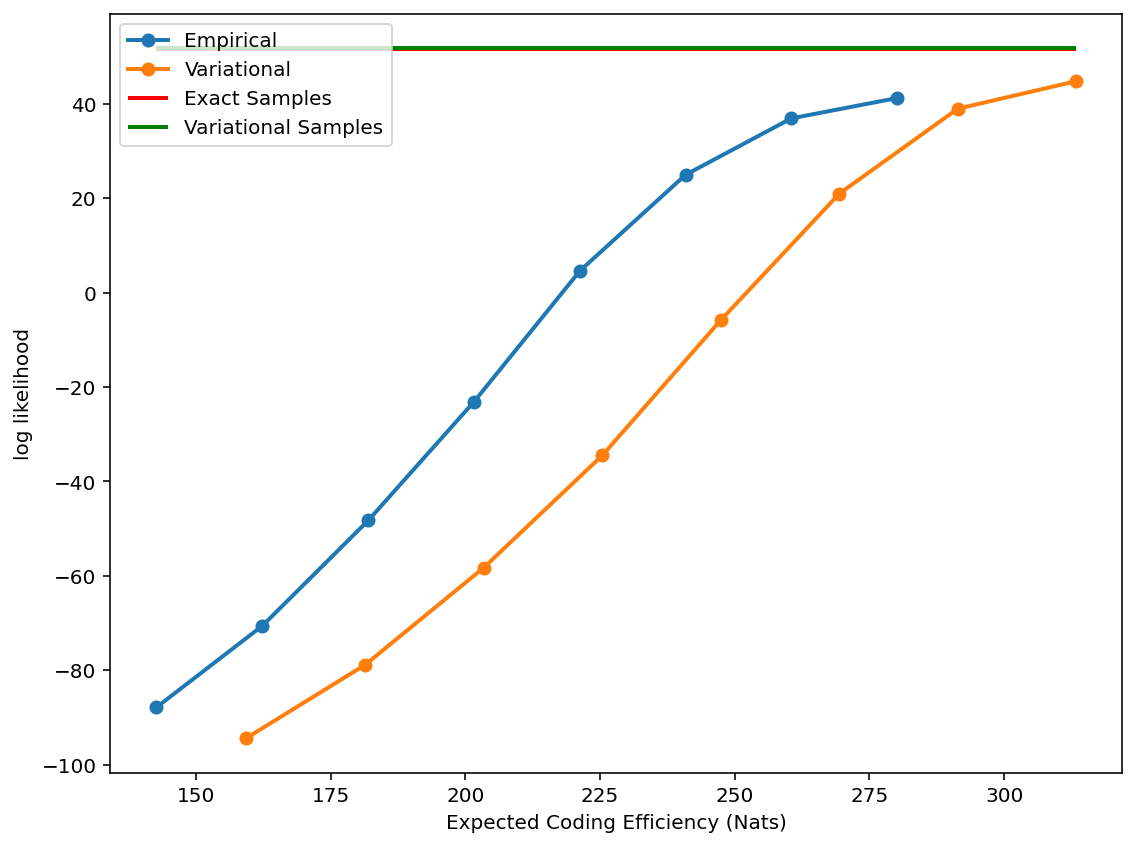

In [601]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(emp_coding_efficiency, emp_log_probs_train, '-o', label='Empirical')
ax.plot(var_coding_efficiency, var_log_probs_train, '-o', label='Variational')
min_x = torch.min(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
max_x = torch.max(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
ax.hlines(exact_log_probs_train, xmin=min_x, xmax=max_x, color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs_train, xmin=min_x, xmax=max_x, color='green', label='Variational Samples')
ax.set_xlabel(r'Expected Coding Efficiency (Nats)')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

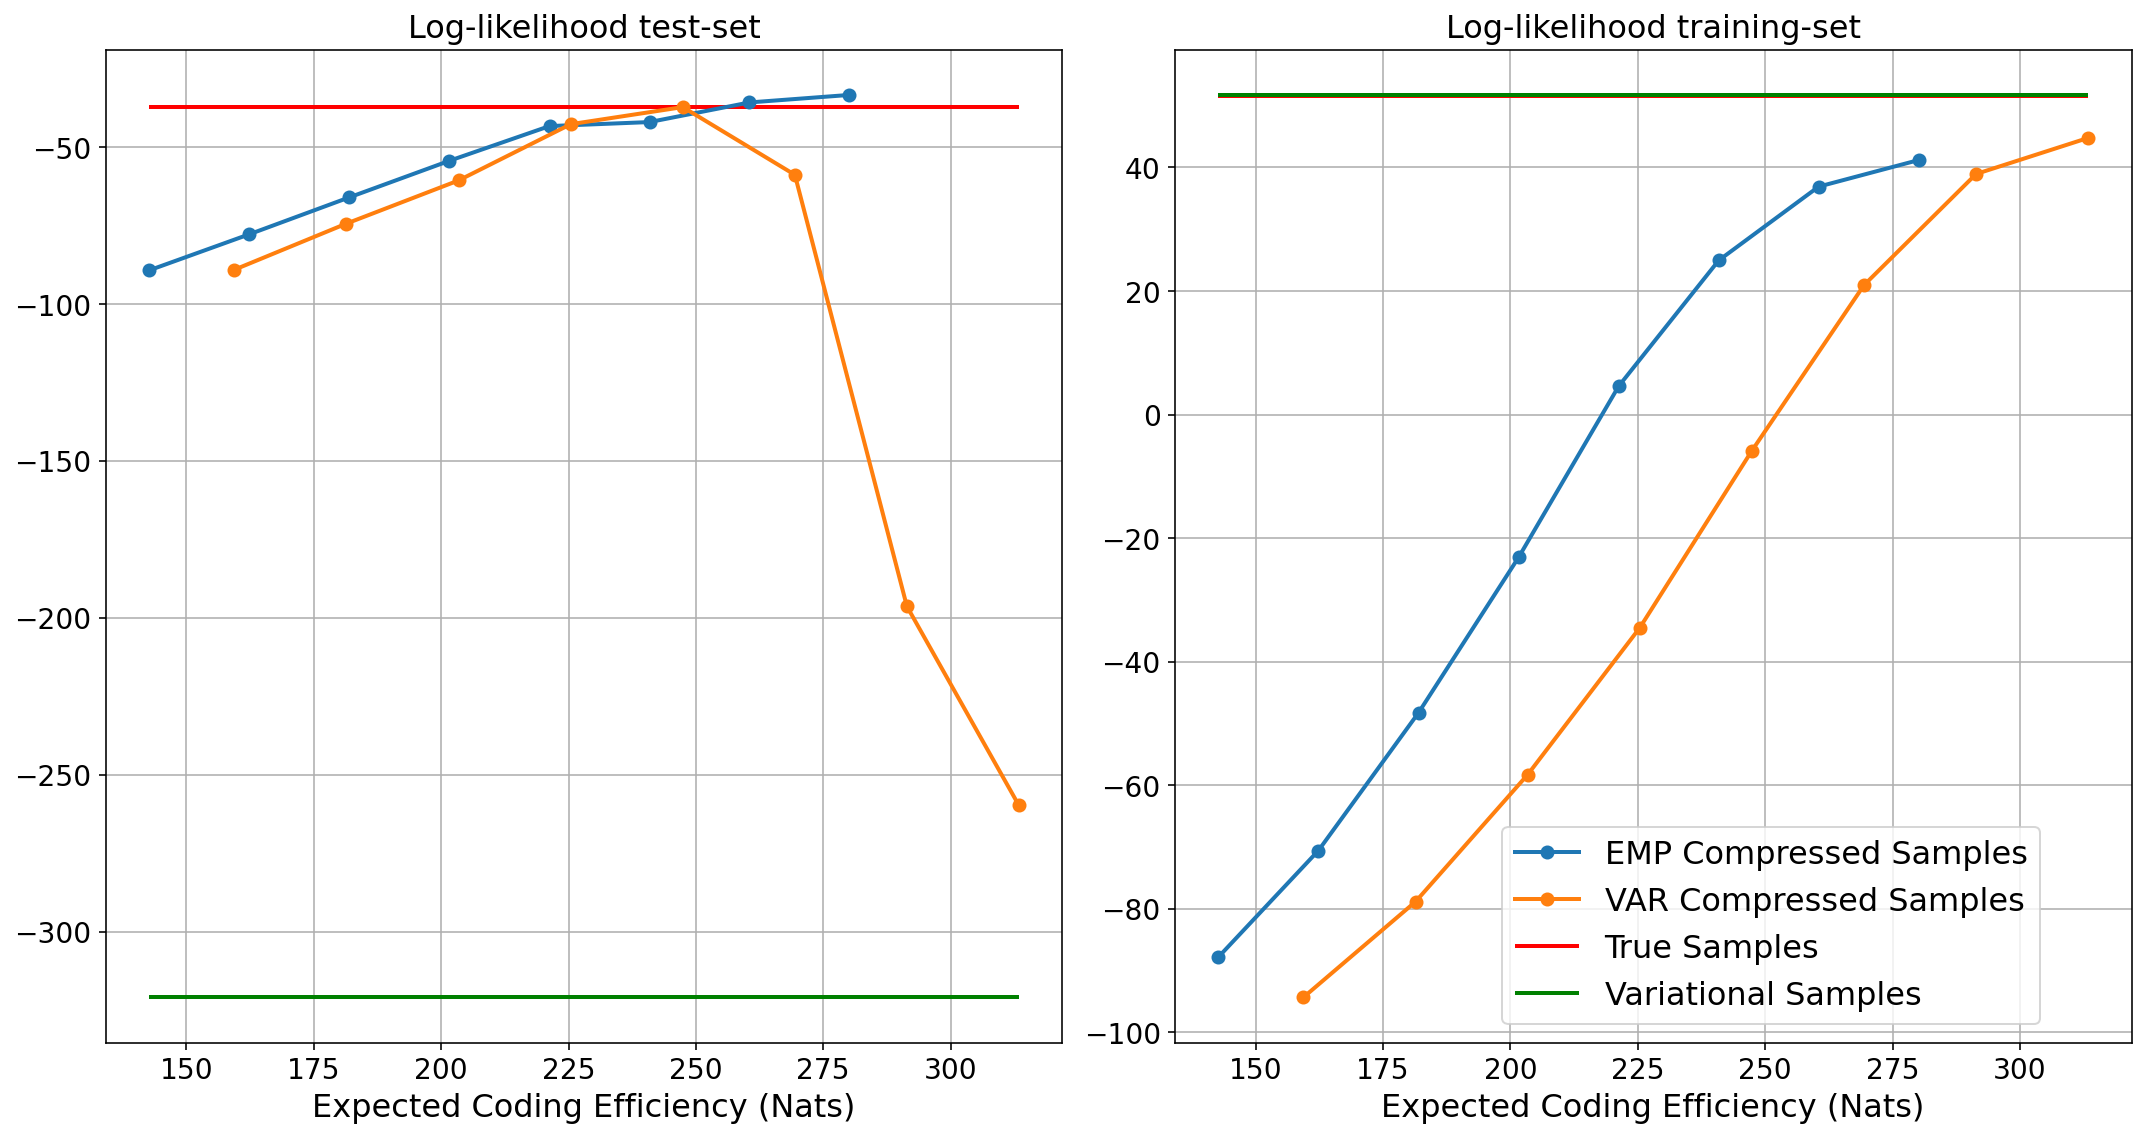

In [602]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
min_x = torch.min(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
max_x = torch.max(torch.tensor(emp_coding_efficiency + var_coding_efficiency))
ax[0].plot(emp_coding_efficiency, emp_log_probs, '-o', label='Empirical')
ax[0].plot(var_coding_efficiency, var_log_probs, '-o', label='Variational')
ax[0].hlines(exact_log_probs, xmin=min_x, xmax=max_x, color='red', label='Exact Samples')
ax[0].hlines(exact_var_log_probs, xmin=min_x, xmax=max_x, color='green', label='Variational Samples')
ax[0].grid()
ax[0].set_xlabel(r'Expected Coding Efficiency (Nats)', fontsize=16)
ax[1].grid()
ax[1].set_xlabel(r'$\epsilon$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[1].plot(emp_coding_efficiency, emp_log_probs_train, '-o', label='Empirical')
ax[1].plot(var_coding_efficiency, var_log_probs_train, '-o', label='Variational')
ax[1].set_xlabel(r'Expected Coding Efficiency (Nats)', fontsize=16)
ax[1].hlines(exact_log_probs_train, xmin=min_x, xmax=max_x, color='red', label='Exact Samples')
ax[1].hlines(exact_var_log_probs_train, xmin=min_x, xmax=max_x, color='green', label='Variational Samples')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP Compressed Samples', 'VAR Compressed Samples', 'True Samples', 'Variational Samples'], loc = (0.7, 0.1), ncol=1, fontsize=16)
f.tight_layout()

# Ensemble LL - Gaussian Predictive

## Test set

In [291]:
emp_kl = D.kl_divergence(t, b.weight_prior)

In [292]:
var_kl = D.kl_divergence(compute_variational_posterior(t), b.weight_prior)

In [293]:
exact_log_probs_gauss = compute_gaussian_likelihood(true_preds(b)[None], b.regression_targets_test, b)

In [294]:
exact_var_log_probs_gauss = compute_gaussian_likelihood(var_approx_preds(b)[None], b.regression_targets_test, b)

In [295]:
vari_full_preds = torch.zeros(len(epsilons), 500, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 500, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

IndexError: list index out of range

In [ ]:
var_log_probs_gauss = compute_gaussian_likelihood(vari_full_preds, b.regression_targets_test, b)

In [ ]:
var_log_probs_gauss.shape

In [296]:
emp_log_probs_gauss = compute_gaussian_likelihood(emp_full_preds, b.regression_targets_test, b)

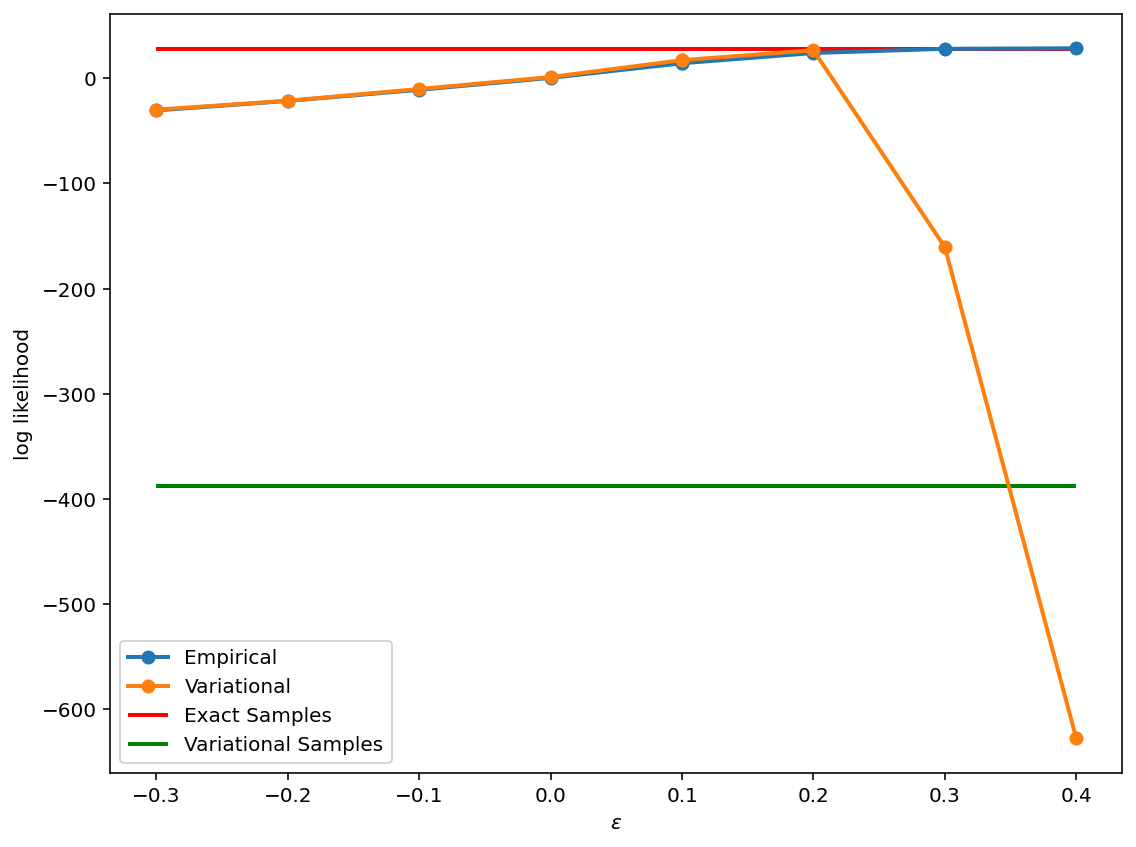

In [328]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs_gauss, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs_gauss, '-o', label='Variational')
ax.hlines(exact_log_probs_gauss, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs_gauss, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

## Training set

In [329]:
exact_log_probs_gauss_train = compute_gaussian_likelihood(true_preds(b, training_data=True)[None], b.regression_targets_train, b)

In [330]:
exact_var_log_probs_gauss_train = compute_gaussian_likelihood(var_approx_preds(b, training_data=True)[None], b.regression_targets_train, b)

In [331]:
var_log_probs_gauss_train = compute_gaussian_likelihood(vari_full_preds_train, b.regression_targets_train, b)

In [332]:
emp_log_probs_gauss_train = compute_gaussian_likelihood(emp_full_preds_train, b.regression_targets_train, b)

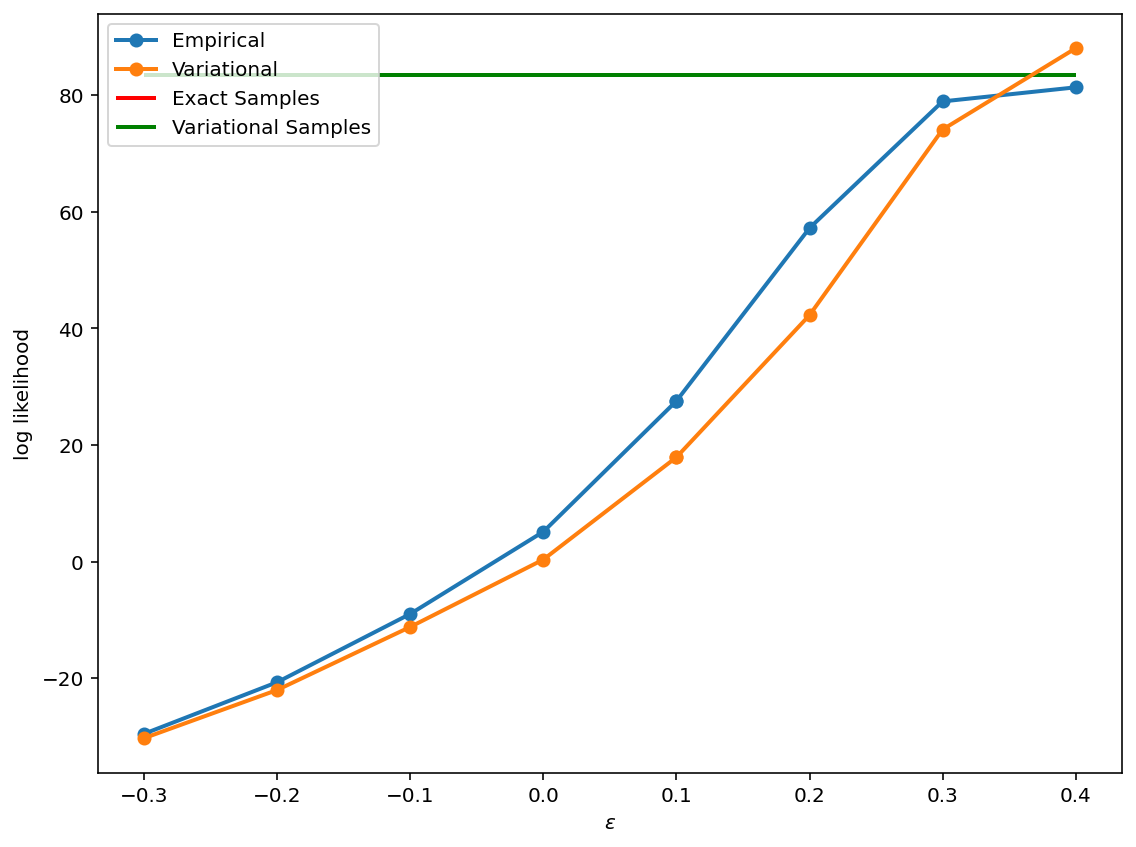

In [333]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs_gauss_train, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs_gauss_train, '-o', label='Variational')
ax.hlines(exact_log_probs_gauss_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs_gauss_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

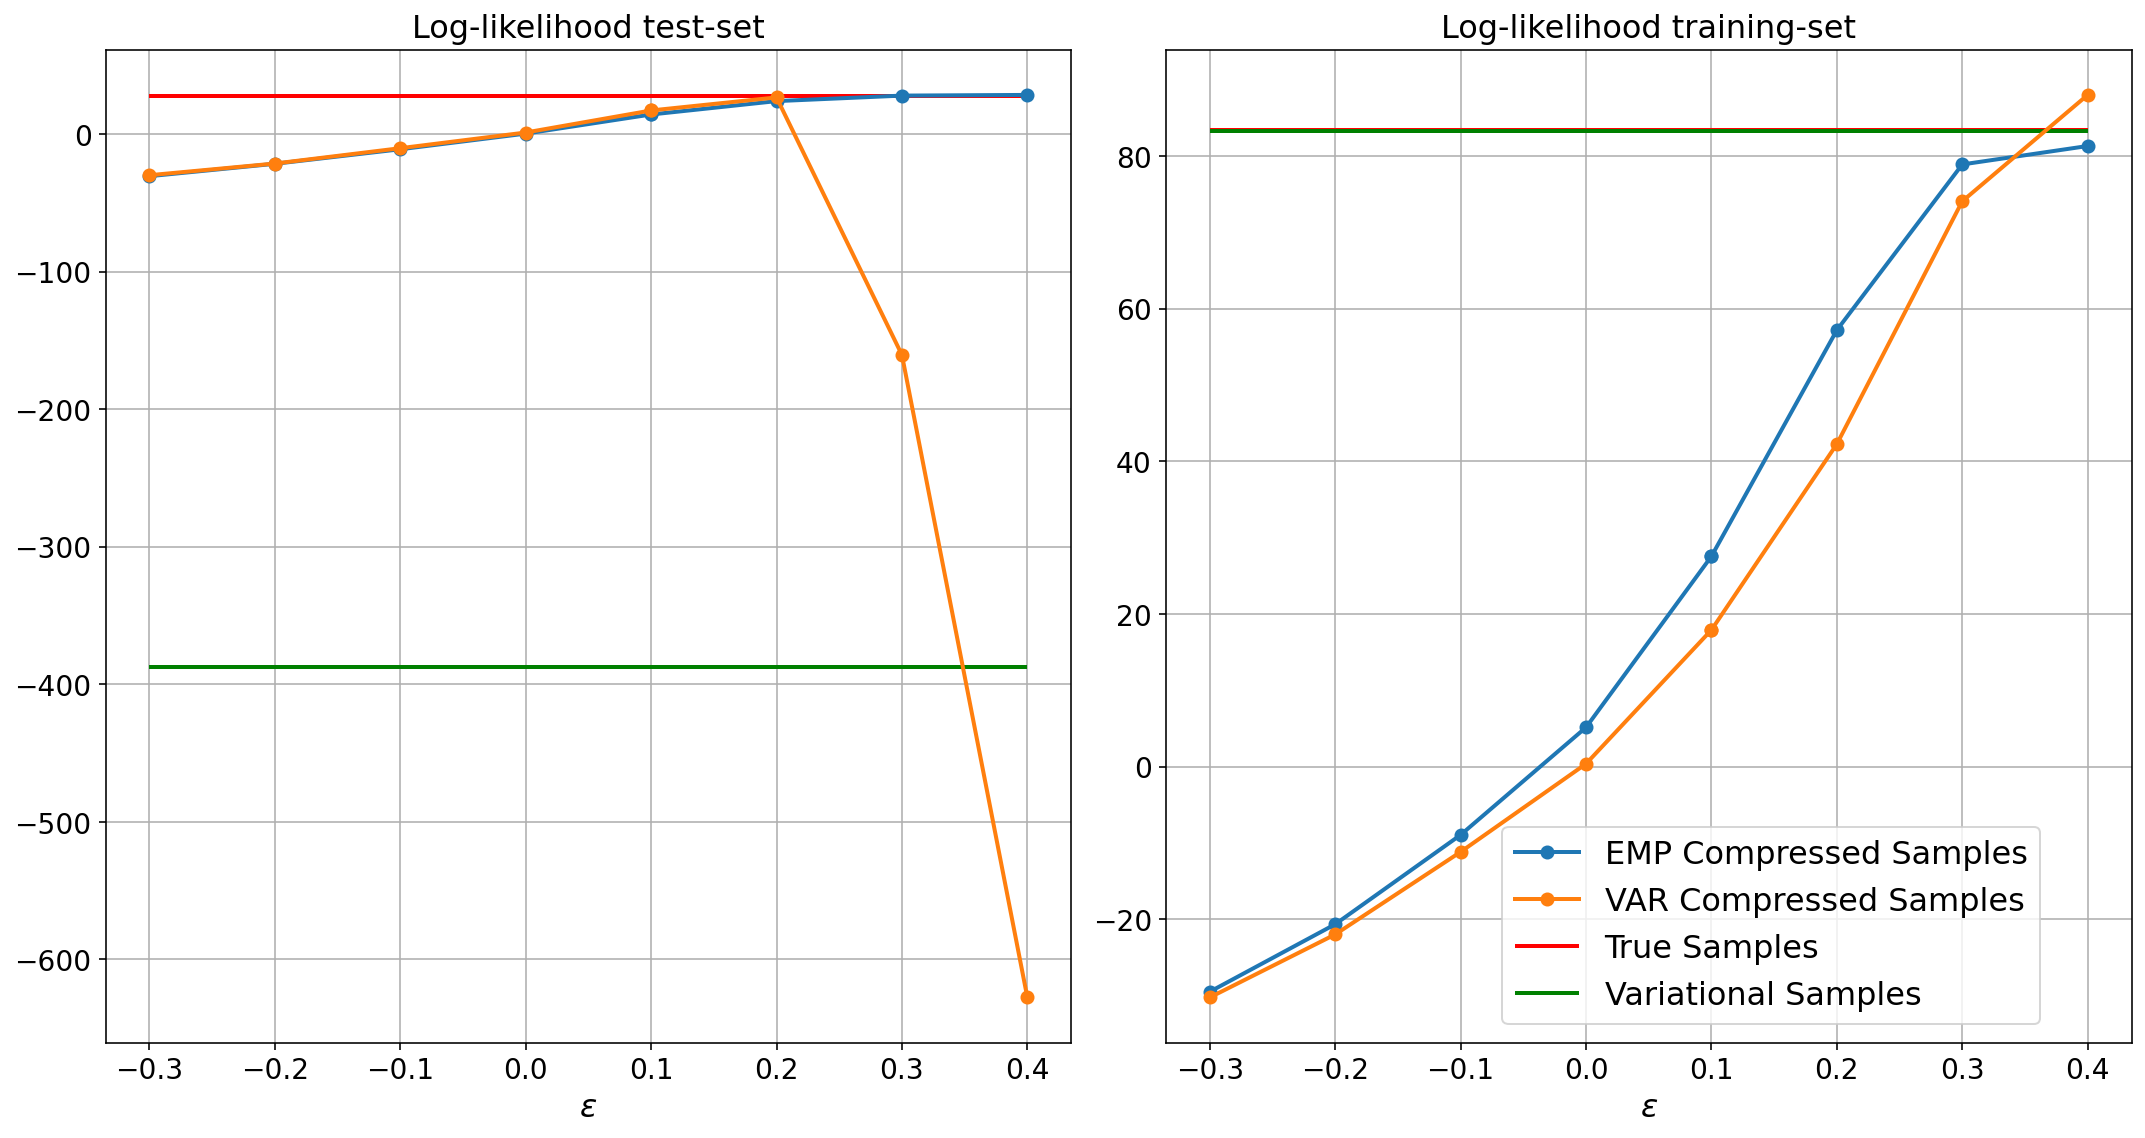

In [334]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(epsilons, emp_log_probs_gauss, '-o', label='Empirical')
ax[0].plot(epsilons, var_log_probs_gauss, '-o', label='Variational')
ax[0].hlines(exact_log_probs_gauss, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[0].hlines(exact_var_log_probs_gauss, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].grid()
ax[0].set_xlabel(r'$\epsilon$', fontsize=16)
ax[1].grid()
ax[1].set_xlabel(r'$\epsilon$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[1].plot(epsilons, emp_log_probs_gauss_train, '-o', label='Empirical')
ax[1].plot(epsilons, var_log_probs_gauss_train, '-o', label='Variational')
ax[1].hlines(exact_log_probs_gauss_train, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[1].hlines(exact_var_log_probs_gauss_train, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP Compressed Samples', 'VAR Compressed Samples', 'True Samples', 'Variational Samples'], loc = (0.7, 0.1), ncol=1, fontsize=16)
f.tight_layout()

# MSE

## Test

In [ ]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [ ]:
exact_rmse = torch.sqrt(((exact_preds.mean(0) - b.regression_targets_test) ** 2 / exact_preds.var(0)).mean())

In [ ]:
var_rmse = torch.sqrt(((var_preds.mean(0) - b.regression_targets_test) ** 2 / var_preds.var(0)).mean())

In [ ]:
emp_rmse = torch.sqrt(((emp_full_preds.mean(1) - b.regression_targets_test) ** 2 / emp_full_preds.var(1)).mean(1))

In [ ]:
vari_rmse=torch.sqrt(((vari_full_preds.mean(1) - b.regression_targets_test) ** 2 / vari_full_preds.var(1)).mean(1))

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_rmse, '-o', label='Empirical')
ax.plot(epsilons, vari_rmse, '-o', label='Variational')
ax.hlines(exact_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_rmse, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised RMSE')
ax.legend()
fig.tight_layout()

## train

In [ ]:
exact_preds_train = true_preds(b, training_data=True)
var_preds_train = var_approx_preds(b, training_data=True)

In [ ]:
exact_rmse_train = torch.sqrt(((exact_preds_train.mean(0) - b.regression_targets_train) ** 2 / exact_preds_train.var(0)).mean())

In [ ]:
var_rmse_train = torch.sqrt(((var_preds_train.mean(0) - b.regression_targets_train) ** 2 / var_preds_train.var(0)).mean())

In [ ]:
emp_rmse_train = torch.sqrt(((emp_full_preds_train.mean(1) - b.regression_targets_train) ** 2 / emp_full_preds_train.var(1)).mean(1))

In [ ]:
vari_rmse_train =torch.sqrt(((vari_full_preds_train.mean(1) - b.regression_targets_train) ** 2 / vari_full_preds_train.var(1)).mean(1))

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_rmse_train, '-o', label='Empirical Compressed Samples GMM')
ax.plot(epsilons, vari_rmse_train, '-o', label='Variational Compressed Samples GMM')
ax.hlines(exact_rmse_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Full Covariance Predictive')
ax.hlines(var_rmse_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Predictive')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised RMSE')
ax.legend()
fig.tight_layout()

# MAE

## Test

In [ ]:
exact_preds = true_preds(b)
var_preds = var_approx_preds(b)

In [ ]:
exact_mae = (torch.abs(exact_preds.mean(0) - b.regression_targets_test) / exact_preds.std(0)).mean()

In [ ]:
var_mae = (torch.abs(var_preds.mean(0) - b.regression_targets_test) / var_preds.std(0)).mean()

In [ ]:
emp_mae = (torch.abs(emp_full_preds.mean(1) - b.regression_targets_test) / emp_full_preds.std(1)).mean(1)

In [ ]:
vari_mae = (torch.abs(vari_full_preds.mean(1) - b.regression_targets_test) / vari_full_preds.std(1)).mean(1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_mae, '-o', label='Empirical')
ax.plot(epsilons, vari_mae, '-o', label='Variational')
ax.hlines(exact_mae, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_mae, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised MAE')
ax.legend()
fig.tight_layout()

## train

In [ ]:
exact_mae_train = (torch.abs(exact_preds_train.mean(0) - b.regression_targets_train) / exact_preds_train.std(0)).mean()

In [ ]:
var_mae_train = (torch.abs(var_preds_train.mean(0) - b.regression_targets_train) / var_preds_train.std(0)).mean()

In [ ]:
emp_mae_train = (torch.abs(emp_full_preds_train.mean(1) - b.regression_targets_train) / emp_full_preds_train.std(1)).mean(1)

In [ ]:
vari_mae_train = (torch.abs(vari_full_preds_train.mean(1) - b.regression_targets_train) / vari_full_preds_train.std(1)).mean(1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_mae_train, '-o', label='Empirical')
ax.plot(epsilons, vari_mae_train, '-o', label='Variational')
ax.hlines(exact_mae_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(var_mae_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Standardised MAE')
ax.legend()
fig.tight_layout()

# Summary Table

## Test Set

In [ ]:
import pandas as pd

In [ ]:
summary_test = pd.DataFrame(index=['True Posterior', 'Compressed EMP', 'Variational Posterior', 'Compressed VAR'],
                            columns=['Log-likelihood', 'SRMSE', 'SMAE', 'Expected Coding Efficiency (Nats)'])

In [ ]:
summary_test.loc['True Posterior'] = [float(exact_log_probs.numpy()), float(exact_rmse.numpy()), float(exact_mae.numpy()), float('nan')]

summary_test.loc['Variational Posterior'] = [float(exact_var_log_probs.numpy()), float(var_rmse.numpy()), float(var_mae.numpy()), float('nan')]

In [ ]:
summary_test.loc['Compressed EMP'] = [float(emp_log_probs.numpy()[0]), float(emp_rmse.numpy()[0]), float(emp_mae.numpy()[0]), emp_coding_efficiency[0]]
summary_test.loc['Compressed VAR'] = [float(var_log_probs.numpy()[0]), float(vari_rmse.numpy()[0]), float(vari_mae.numpy()[0]), var_coding_efficiency[0]]

In [ ]:
summary_test.astype(float).round(2).mask(summary_test.isna(), 'N/A')

## Train Set

In [ ]:
emp_coding_efficiency = torch.tensor([compute_expected_coding_efficiency(emp_kl, epsilon=e) for e in epsilons])

In [ ]:
var_coding_efficiency = torch.tensor([compute_expected_coding_efficiency(var_kl, epsilon=e) for e in epsilons])

In [ ]:
import pandas as pd

In [ ]:
summary_train = pd.DataFrame(index=['True Posterior', 'Compressed EMP', 'Variational Posterior', 'Compressed VAR'],
                            columns=['Log-likelihood', 'SRMSE', 'SMAE', 'Expected Coding Efficiency (Nats)'])

In [ ]:
summary_train.loc['True Posterior'] = [float(exact_log_probs_train.numpy()), float(exact_rmse_train.numpy()), float(exact_mae_train.numpy()), float('nan')]

summary_train.loc['Variational Posterior'] = [float(exact_var_log_probs_train.numpy()), float(var_rmse_train.numpy()), float(var_mae_train.numpy()), float('nan')]

In [ ]:
summary_train.loc['Compressed EMP'] = [float(emp_log_probs_train.numpy()[0]), float(emp_rmse_train.numpy()[0]), float(emp_mae_train.numpy()[0]), emp_coding_efficiency[0]]
summary_train.loc['Compressed VAR'] = [float(var_log_probs_train.numpy()[0]), float(vari_rmse_train.numpy()[0]), float(vari_mae_train.numpy()[0]), var_coding_efficiency[0]]

In [ ]:
summary_train.astype(float).round(2).mask(summary_train.isna(), 'N/A')